<a href="https://colab.research.google.com/github/Mishra-0709/Myntra-BlackGriffin/blob/main/myntra2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

100%|██████████| 6.25M/6.25M [00:00<00:00, 76.3MB/s]



0: 640x448 2 persons, 1 handbag, 428.8ms
Speed: 14.5ms preprocess, 428.8ms inference, 33.1ms postprocess per image at shape (1, 3, 640, 448)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Detected skin tone: medium
Recommended colors: ['#0000FF', '#4c3d38', '#819fa2']


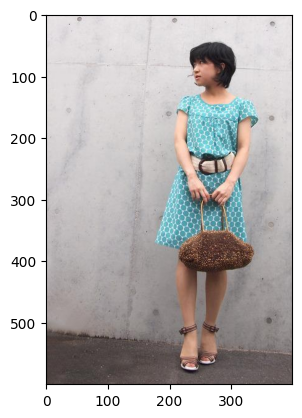

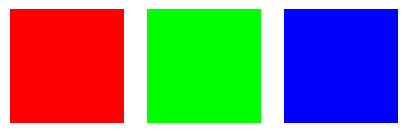

In [3]:
# Ensure you have the necessary libraries installed
!pip install ultralytics opencv-python-headless scikit-learn matplotlib pillow

import cv2
import numpy as np
from ultralytics import YOLO
import random
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import os

# Load YOLO model
model = YOLO('yolov8n.pt')  # or use a more specific model trained for clothing detection

def get_dominant_colors(image, n_colors=3):
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)

    # Get the colors
    colors = kmeans.cluster_centers_

    # Convert to hex
    hex_colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in colors]

    return hex_colors

def detect_clothing_and_colors(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform YOLO detection
    results = model(image)

    # Extract clothing items
    clothing_items = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            class_id = int(box.cls[0])
            if model.names[class_id] in ['person', 'shirt', 'dress', 'pants']:  # Add more clothing classes as needed
                clothing_items.append(image[y1:y2, x1:x2])

    # Extract dominant colors
    dominant_colors = []
    for item in clothing_items:
        colors = get_dominant_colors(item)
        dominant_colors.extend(colors)

    return list(set(dominant_colors))[:10]  # Return up to 10 unique colors

def detect_skin_tone(image_path):
    # For simplicity, we'll use a basic approach to detect skin tone
    # In a real-world scenario, you'd want a more sophisticated method
    image = cv2.imread(image_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        return "medium"  # Default if no face detected

    (x, y, w, h) = faces[0]
    face_roi = image[y:y+h, x:x+w]
    average_color = np.mean(face_roi, axis=(0, 1))

    # Simplified skin tone classification
    b, g, r = average_color
    if r > 200 and g > 200 and b > 200:
        return "very_fair"
    elif r > 180 and g > 180 and b > 180:
        return "fair"
    elif r > 160 and g > 160 and b > 160:
        return "light"
    elif r > 140 and g > 140 and b > 140:
        return "medium_light"
    elif r > 120 and g > 120 and b > 120:
        return "medium"
    elif r > 100 and g > 100 and b > 100:
        return "medium_tan"
    elif r > 80 and g > 80 and b > 80:
        return "tan"
    else:
        return "dark"

# Define skin tone to color recommendations (simplified version)
skin_tone_colors = {
    "very_fair": ["#FFD700", "#008080", "#800080", "#FF69B4", "#4B0082", "#00CED1", "#FF4500", "#1E90FF", "#32CD32", "#FF1493"],
    "fair": ["#FF6347", "#4682B4", "#9ACD32", "#FF69B4", "#8A2BE2", "#20B2AA", "#FF4500", "#4169E1", "#32CD32", "#FF1493"],
    "light": ["#FFA07A", "#6495ED", "#7FFF00", "#DDA0DD", "#9932CC", "#48D1CC", "#FF6347", "#1E90FF", "#3CB371", "#FF69B4"],
    "medium_light": ["#F4A460", "#4169E1", "#32CD32", "#DA70D6", "#8B008B", "#40E0D0", "#FF4500", "#1E90FF", "#228B22", "#FF1493"],
    "medium": ["#CD853F", "#0000FF", "#228B22", "#BA55D3", "#9400D3", "#00CED1", "#FF6347", "#4682B4", "#2E8B57", "#FF69B4"],
    "medium_tan": ["#D2691E", "#0000CD", "#006400", "#9370DB", "#8B008B", "#20B2AA", "#FF4500", "#4169E1", "#2E8B57", "#FF1493"],
    "tan": ["#8B4513", "#000080", "#006400", "#8A2BE2", "#4B0082", "#008B8B", "#B22222", "#4682B4", "#228B22", "#C71585"],
    "dark": ["#A0522D", "#191970", "#006400", "#9932CC", "#4B0082", "#008080", "#8B0000", "#4169E1", "#2E8B57", "#C71585"],
}

def recommend_colors(image_path):
    # Detect skin tone
    skin_tone = detect_skin_tone(image_path)

    # Get dominant colors from clothing
    dominant_colors = detect_clothing_and_colors(image_path)

    # Update skin tone color recommendations with dominant colors
    if skin_tone in skin_tone_colors:
        skin_tone_colors[skin_tone] = list(set(skin_tone_colors[skin_tone] + dominant_colors))

    # Recommend colors
    recommended_colors = random.sample(skin_tone_colors[skin_tone], min(3, len(skin_tone_colors[skin_tone])))

    return skin_tone, recommended_colors

def within_threshold(check, threshold):
    avg = sum(check) / 3
    if avg > 230:
        return True
    return all(avg - threshold <= value <= avg + threshold for value in check)

def euclidean_sim(arr, check):
    for ele in arr:
        ele = [e-a for e,a in zip(ele,check)]
        res = np.linalg.norm(ele)/442.4
        if res <= 0.2:
            return False
        if within_threshold(check, 5):
            return False
    return True

def getSkinToneClothColor(image_path):
    # Detect skin tone
    skin_tone = detect_skin_tone(image_path)

    image = cv2.imread(image_path)
    results = model(image)

    cropped_image = cv2.imread(image_path)
    labels = results.xyxyn[0][:, -1].numpy()
    coords = results.xyxyn[0][:, :-1].numpy()

    for i in range(0, len(labels)):
        # as 0 represents person in coco dataset
        if labels[i] == 0:
            x1, y1, x2, y2, pred = coords[i]
            height, width, _ = image.shape
            x1, y1, x2, y2 = int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)
            cropped_image = cropped_image[y1:y2, x1:x2]
            break

    height, width, _ = np.shape(cropped_image)
    data = np.reshape(cropped_image, (height * width, 3))
    data = np.float32(data)

    number_clusters = 7
    kmeans = KMeans(n_clusters=number_clusters)
    kmeans.fit(data)

    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    rgb_values = []

    for index, row in enumerate(centers):
        # Extract RGB values from the row
        b, g, r = int(row[0]), int(row[1]), int(row[2])
        # put a check of cosine similarity
        if euclidean_sim(rgb_values, [r, g, b]):
            rgb_values.append([r, g, b])

    return skin_tone, rgb_values

def main():
    # Example usage
    image_path = "/content/1.jpg"  # Replace with your image path
    if not os.path.exists(image_path):
        print(f"Error: Image file '{image_path}' not found.")
        return

    skin_tone, recommended_colors = recommend_colors(image_path)
    print(f"Detected skin tone: {skin_tone}")
    print(f"Recommended colors: {recommended_colors}")

    # Prepare a single color dictionary entry for demonstration
    color_dict = {
        "#373028": [[255, 0, 0], [0, 255, 0], [0, 0, 255]]  # Example colors
    }

    # Save JSON data
    json_data = json.dumps(color_dict)
    with open('data.json', 'w') as f:
        f.write(json_data)

def display_color_recommendations():
    if not os.path.exists('data.json'):
        print("Error: 'data.json' file not found.")
        return

    with open('data.json', 'r') as f:
        json_data = json.load(f)

    image_path = '/content/1.jpg'  # Replace with your image path
    if not os.path.exists(image_path):
        print(f"Error: Image file '{image_path}' not found.")
        return

    try:
        # Try to open the image with OpenCV first
        cv_image = cv2.imread(image_path)
        if cv_image is None:
            raise UnidentifiedImageError(f"Error: Unable to read the image file '{image_path}' with OpenCV.")

        # Convert the image to a format PIL can use
        cv_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(cv_image_rgb)
    except UnidentifiedImageError:
        print(f"Error: Unable to identify the image file '{image_path}'.")
        return

    # Display the image and recommended colors
    plt.imshow(pil_image)
    suggestions = random.sample(json_data[list(json_data.keys())[0]], 3)
    fig, axs = plt.subplots(1, 3, figsize=(5, 3))

    for i, color in enumerate(suggestions):
        r, g, b = color
        axs[i].imshow([[[r/255, g/255, b/255]]])
        axs[i].axis('off')

    plt.show()

if __name__ == "__main__":
    main()
    display_color_recommendations()